In [1]:
import numpy as np
import torch.nn.functional as F


In [5]:
s = "415"
s = [ord(c)-ord('0') for c in s]
s = [4, 1, 5]
h = 0
for c in s:
    h = 10*h + c
h

415

# Stateful LSTM to learn one-char to one-char mapping

From https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

In [146]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import np_utils
# fix random seed for reproducibility
numpy.random.seed(7)
# define the raw dataset
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# create mapping of characters to integers (0-25) and the reverse
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
# prepare the dataset of input to output pairs encoded as integers
seq_length = 1
dataX = []
dataY = []
for i in range(0, len(alphabet) - seq_length, 1):
	seq_in = alphabet[i:i + seq_length]
	seq_out = alphabet[i + seq_length]
	dataX.append([char_to_int[char] for char in seq_in])
	dataY.append(char_to_int[seq_out])
	#print(seq_in, '->', seq_out)
dataX = np.array(dataX)
dataY = np.array(dataY)

Using TensorFlow backend.


In [147]:
dataX.shape, dataY.shape

((25, 1), (25,))

In [148]:
# reshape X to be [samples, time steps, features]
X = dataX.reshape(len(dataX), seq_length, 1)
dataX.shape

(25, 1)

In [149]:
# normalize
X = X / float(len(alphabet))
# one hot encode the output variable
y = np_utils.to_categorical(dataY)
y.shape

(25, 26)

In [150]:
# create and fit the model
batch_size = 1
model = Sequential()
model.add(LSTM(50, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
for i in range(300):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	model.reset_states()
# summarize performance of the model
scores = model.evaluate(X, y, batch_size=batch_size, verbose=0)
model.reset_states()
print("Model Accuracy: %.2f%%" % (scores[1]*100))
# demonstrate some model predictions
seed = [char_to_int[alphabet[0]]]
for i in range(0, len(alphabet)-1):
	x = numpy.reshape(seed, (1, len(seed), 1))
	x = x / float(len(alphabet))
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	print(int_to_char[seed[0]], "->", int_to_char[index])
	seed = [index]
model.reset_states()
# demonstrate a random starting point
letter = "K"
seed = [char_to_int[letter]]
print("New start: ", letter)
for i in range(0, 5):
	x = numpy.reshape(seed, (1, len(seed), 1))
	x = x / float(len(alphabet))
	prediction = model.predict(x, verbose=0)
	index = numpy.argmax(prediction)
	print(int_to_char[seed[0]], "->", int_to_char[index])
	seed = [index]
model.reset_states()

Epoch 1/1
 - 0s - loss: 3.2735 - accuracy: 0.0400
Epoch 1/1
 - 0s - loss: 3.2487 - accuracy: 0.0800
Epoch 1/1
 - 0s - loss: 3.2336 - accuracy: 0.0800
Epoch 1/1
 - 0s - loss: 3.2160 - accuracy: 0.0800
Epoch 1/1
 - 0s - loss: 3.1902 - accuracy: 0.1200
Epoch 1/1
 - 0s - loss: 3.1442 - accuracy: 0.0800
Epoch 1/1
 - 0s - loss: 3.0636 - accuracy: 0.0800
Epoch 1/1
 - 0s - loss: 2.9888 - accuracy: 0.0800
Epoch 1/1
 - 0s - loss: 2.9734 - accuracy: 0.1200
Epoch 1/1
 - 0s - loss: 3.1077 - accuracy: 0.1600
Epoch 1/1
 - 0s - loss: 2.9052 - accuracy: 0.1600
Epoch 1/1
 - 0s - loss: 2.8687 - accuracy: 0.2000
Epoch 1/1
 - 0s - loss: 2.7826 - accuracy: 0.2000
Epoch 1/1
 - 0s - loss: 2.7037 - accuracy: 0.1600
Epoch 1/1
 - 0s - loss: 2.5799 - accuracy: 0.2000
Epoch 1/1
 - 0s - loss: 2.4276 - accuracy: 0.3600
Epoch 1/1
 - 0s - loss: 2.7185 - accuracy: 0.2400
Epoch 1/1
 - 0s - loss: 2.4084 - accuracy: 0.1600
Epoch 1/1
 - 0s - loss: 3.1794 - accuracy: 0.0800
Epoch 1/1
 - 0s - loss: 2.8143 - accuracy: 0.1200


KeyboardInterrupt: 

## Loss functions

In [151]:
def cross_entropy(y_prob, y_true):
    """
    y_pred is n x k for n samples and k output classes and y_true is n x 1
    and is often softmax of final layer.
    y_pred values must be probability that output is a specific class.
    Binary case: When we have y_pred close to 1 and y_true is 1,
    loss is -1*log(1)==0. If y_pred close to 0 and y_true is 1, loss is
    -1*log(small value) = big value.
    y_true values must be positive integers in [0,k-1].
    """
    n = y_prob.shape[0]
    # Get valid at y_true[j] for each sample with fancy indexing
    p = y_prob[range(n),y_true]
    return np.mean(-np.log(p))

In [152]:
def softmax(y):
    ey = np.exp(y)
    if len(y.shape)==1:
        return ey / np.sum(ey)
    return ey /np.sum(ey, axis=1).reshape(-1,1)

In [153]:
a = np.array([1.0, 2.0, 3.0, 4.0, 1.0, 2.0, 3.0])
softmax(a)

array([0.02364054, 0.06426166, 0.1746813 , 0.474833  , 0.02364054,
       0.06426166, 0.1746813 ])

In [162]:
y_true = np.array([1,2,3,2,3,1])
n = len(y_true)
k = np.max(y_true)+1
y_pred = np.random.random(size=(n,k))*3 # mimic unnormalized final layer output
y_pred

array([[1.04536842, 2.88283144, 0.43578041, 1.69857678],
       [0.55438678, 0.4302623 , 0.50218948, 0.92517536],
       [2.39428275, 2.58348557, 0.90331706, 0.1649929 ],
       [2.32816417, 1.78824153, 0.84542821, 1.19726932],
       [1.40387195, 1.8405467 , 1.79338658, 0.37704829],
       [1.57733775, 2.97189155, 0.53064241, 1.59529061]])

In [163]:
softmax(y_pred)

array([[0.10260772, 0.64443643, 0.05577497, 0.19718089],
       [0.23357456, 0.20630937, 0.22169533, 0.33842074],
       [0.39353874, 0.47550734, 0.08860726, 0.04234666],
       [0.46892144, 0.27328429, 0.10645254, 0.15134173],
       [0.22820841, 0.35316453, 0.33689588, 0.08173118],
       [0.15619178, 0.62994871, 0.05483832, 0.15902119]])

In [164]:
y_true

array([1, 2, 3, 2, 3, 1])

In [165]:
p = softmax(y_pred)
p

array([[0.10260772, 0.64443643, 0.05577497, 0.19718089],
       [0.23357456, 0.20630937, 0.22169533, 0.33842074],
       [0.39353874, 0.47550734, 0.08860726, 0.04234666],
       [0.46892144, 0.27328429, 0.10645254, 0.15134173],
       [0.22820841, 0.35316453, 0.33689588, 0.08173118],
       [0.15619178, 0.62994871, 0.05483832, 0.15902119]])

In [166]:
cross_entropy(p, y_true)

1.7190314157337514

In [167]:
# from https://deepnotes.io/softmax-crossentropy
# Warning: this expects raw output not softmax; it does softmax also inside
def deepnotes_cross_entropy(X,y):
    """
    X is the output from fully connected layer (num_examples x num_classes)
    y is labels (num_examples x 1)
    	Note that y is not one-hot encoded vector. 
    	It can be computed as y.argmax(axis=1) from one-hot encoded vectors of labels if required.
    """
    n = y.shape[0]
    p = softmax(X)
    # We use multidimensional array indexing to extract 
    # softmax probability of the correct label for each sample.
    # Refer to https://docs.scipy.org/doc/numpy/user/basics.indexing.html#indexing-multi-dimensional-arrays for understanding multidimensional array indexing.
    log_likelihood = -np.log(p[range(n),y])
    loss = np.sum(log_likelihood) / n
    return loss

In [168]:
deepnotes_cross_entropy(y_pred, y_true)

1.7190314157337514

In [169]:
import torch
# Warning: this expects raw output not softmax; it does softmax also inside
F.cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))

tensor(1.7190, dtype=torch.float64)

In [174]:
a = torch.tensor(range(9)).reshape(3,3)
a

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [176]:
torch.sum(a, dim=1)

tensor([ 3, 12, 21])

In [1]:
import torch
vocab = {c:i for i,c in enumerate("acehktz")}
print(vocab)
torch.zeros(len(vocab))

{'a': 0, 'c': 1, 'e': 2, 'h': 3, 'k': 4, 't': 5, 'z': 6}


tensor([0., 0., 0., 0., 0., 0., 0.])

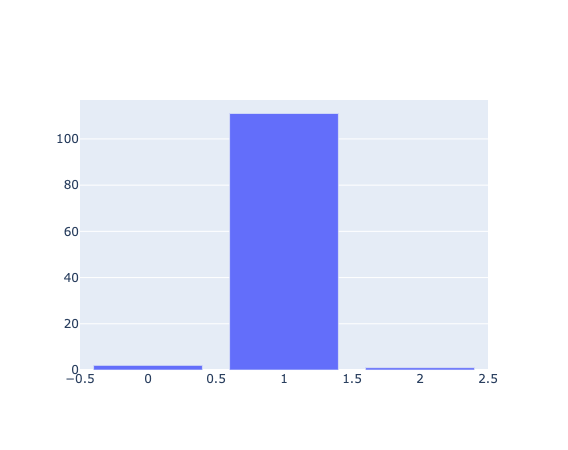

In [2]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Bar(y=[2, 111, 1]))
fig.show()

In [2]:
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = []
    for i in range(m): new_ds += [ds[i + m*j] for j in range(bs)]
    return new_ds

group_chunks(range(10),bs=3)

[0, 3, 6, 1, 4, 7, 2, 5, 8]